# Pneumonia Detection from Chest X-rays using Deep Learning
## Team Gmora - BioFusion Hackathon 2026

---

# 1. Problem Definition

## Clinical and Healthcare Relevance

Pneumonia is one of the leading causes of mortality worldwide, particularly among children and the elderly. According to the World Health Organization:
- **450 million cases** of pneumonia occur annually
- Causes approximately **15% of all deaths** in children under 5 years old
- Accounts for **4 million deaths globally** each year
- Early detection is critical for effective treatment and reducing mortality

## The Problem We're Addressing

**Diagnostic Challenges:**
- Shortage of radiologists, especially in developing countries and rural areas
- Time-intensive manual diagnosis leading to delays in treatment
- High variability in diagnostic accuracy among general practitioners
- Limited access to expert radiologists in low-resource settings

**What We're Predicting:**
This project develops an automated deep learning model to classify chest X-ray images as either:
- **NORMAL**: Healthy lungs with no signs of pneumonia
- **PNEUMONIA**: Presence of pneumonia infection

The model serves as a decision support tool for healthcare professionals, enabling:
- Rapid pre-screening of chest X-rays
- Prioritization of high-risk cases for radiologist review
- Accessible diagnostic support in areas with limited medical expertise

# 2. Dataset Documentation

## Dataset Citation and Source

**Dataset:** Chest X-Ray Images (Pneumonia)  
**Source:** Kaggle - Paul Mooney  
**URL:** https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia  
**Original Source:** Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018). Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification. Mendeley Data, v2.

**Description:** The dataset contains 5,863 chest X-ray images (JPEG) organized into 3 folders (train, test, val) with 2 categories (Pneumonia/Normal). Chest X-ray images were selected from retrospective cohorts of pediatric patients aged 1-5 years from Guangzhou Women and Children's Medical Center, Guangzhou.

In [ ]:
# Install required packages
!pip install -q kagglehub

In [ ]:
# Import libraries
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print('Libraries imported!')
print(f'PyTorch: {torch.__version__}')
print(f'CUDA Available: {torch.cuda.is_available()}')

Libraries imported!
PyTorch: 2.9.0+cu126
CUDA Available: True


## 7. Reproducibility Setup

In [ ]:
# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f'Random seed set to: {SEED}')

Random seed set to: 42


In [ ]:
# Download dataset
path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')
print('Dataset path:', path)
dataset_path = os.path.join(path, 'chest_xray')

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset path: /kaggle/input/chest-xray-pneumonia


## Analyze Dataset Distribution

In [ ]:
def count_images(base_path):
    counts = {}
    for split in ['train', 'test', 'val']:
        split_path = os.path.join(base_path, split)
        counts[split] = {}
        for category in ['NORMAL', 'PNEUMONIA']:
            cat_path = os.path.join(split_path, category)
            if os.path.exists(cat_path):
                counts[split][category] = len([f for f in os.listdir(cat_path) if f.endswith(('.jpeg', '.jpg'))])
    return counts

image_counts = count_images(dataset_path)
for split in ['train', 'val', 'test']:
    print(f"{split.upper()}: NORMAL={image_counts[split]['NORMAL']}, PNEUMONIA={image_counts[split]['PNEUMONIA']}")

TRAIN: NORMAL=1341, PNEUMONIA=3875
VAL: NORMAL=8, PNEUMONIA=8
TEST: NORMAL=234, PNEUMONIA=390


## Visualize Samples

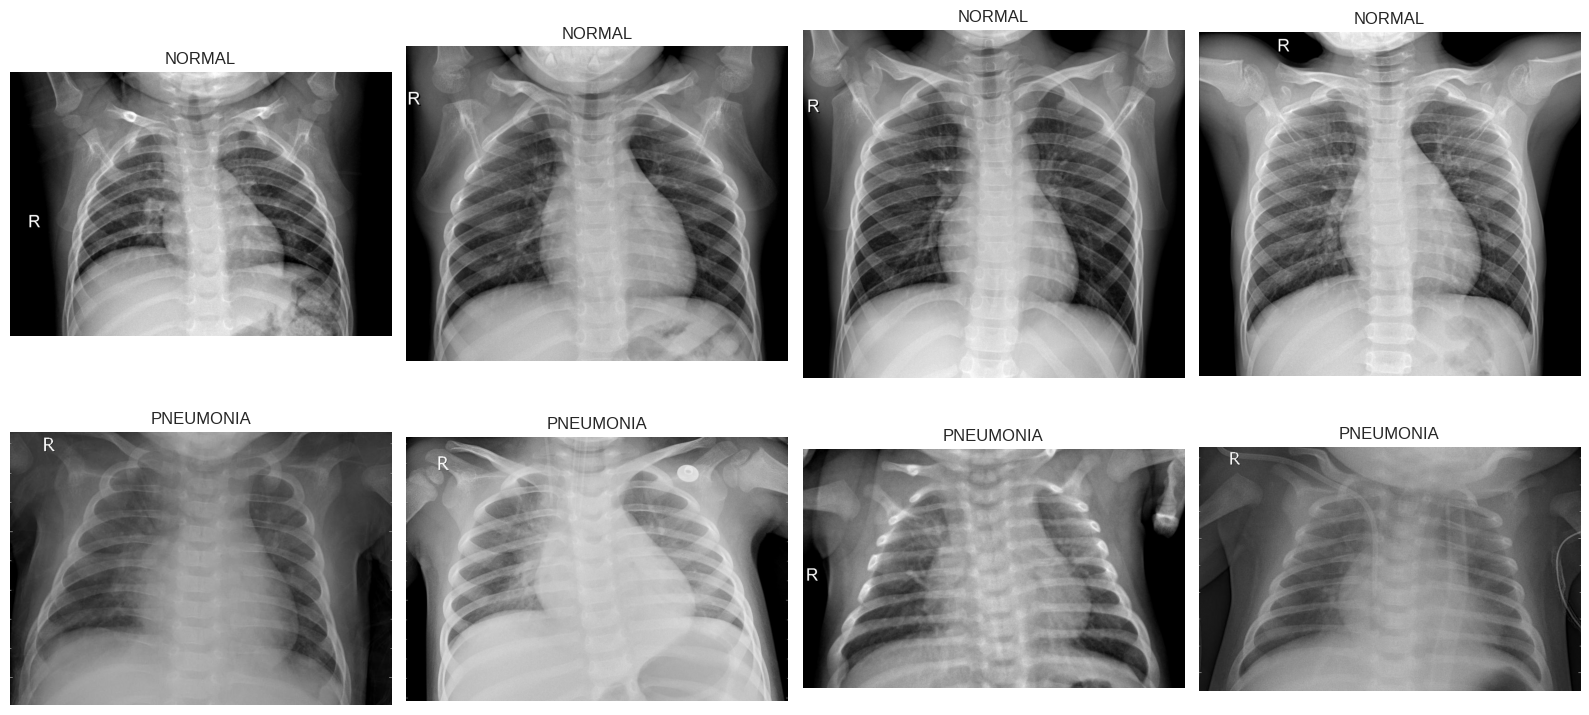

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for row, category in enumerate(['NORMAL', 'PNEUMONIA']):
    cat_path = os.path.join(dataset_path, 'train', category)
    samples = random.sample([f for f in os.listdir(cat_path) if f.endswith('.jpeg')], 4)
    for col, img_file in enumerate(samples):
        img = Image.open(os.path.join(cat_path, img_file))
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'{category}')
plt.tight_layout()
plt.show()

# 3. Data Preprocessing

## Preprocessing Pipeline
- Resize to 224×224 (DenseNet121 input)
- RGB conversion
- ImageNet normalization
- Data augmentation (training only)

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

print('Transforms defined')

Transforms defined


## Custom Dataset Class

In [ ]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['NORMAL', 'PNEUMONIA']
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.endswith(('.jpeg', '.jpg')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

print('Dataset class defined')

Dataset class defined


## Create DataLoaders

In [ ]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

full_train = ChestXrayDataset(train_dir, train_transform)
train_idx, val_idx = train_test_split(list(range(len(full_train))), test_size=0.15, random_state=SEED, stratify=full_train.labels)

train_dataset = torch.utils.data.Subset(full_train, train_idx)
val_full = ChestXrayDataset(train_dir, val_test_transform)
val_dataset = torch.utils.data.Subset(val_full, val_idx)
test_dataset = ChestXrayDataset(test_dir, val_test_transform)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f'Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

def get_dist(dataset):
    if isinstance(dataset, torch.utils.data.Subset):
        labels = [dataset.dataset.labels[i] for i in dataset.indices]
    else:
        labels = dataset.labels
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

train_dist = get_dist(train_dataset)

Train: 4433, Val: 783, Test: 624


# 4. Model Initialization & Pretraining Disclosure

## A. Pretrained Model Information

**Model Name:** DenseNet121 (Densely Connected Convolutional Networks)

**Source:** torchvision.models (PyTorch official model zoo)

**Original Training Task:**
- Trained on ImageNet dataset
- 1000-class image classification
- Natural images from various categories
- 1.2 million training images

**Architecture:** 121 layers deep with dense connections

## B. Weight Usage Declaration

**✅ USING PRETRAINED WEIGHTS** from ImageNet, NOT random initialization.

This provides:
- Transfer learning benefits
- Faster convergence
- Better performance with limited medical data
- Low-level features (edges, textures) transfer well to medical images

# 5. Model Development

## Architecture and Justification

**Why DenseNet121?**
1. Dense connectivity improves gradient flow
2. Used in CheXNet for chest X-ray classification
3. Computational efficiency
4. Proven transfer learning success

**Modifications:**
- Replace final FC layer (1024 → 2 classes)
- Freeze 80% of layers (feature extractor)
- Train final 20% + classifier (domain adaptation)

In [ ]:
# Load pretrained model
model = models.densenet121(pretrained=True)
print('DenseNet121 loaded with ImageNet weights')
print(f'Original classifier: {model.classifier}')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 98.8MB/s]

DenseNet121 loaded with ImageNet weights
Original classifier: Linear(in_features=1024, out_features=1000, bias=True)


## Fine-Tuning Strategy

**Progressive fine-tuning:**
1. Freeze early layers (80%) - preserve ImageNet features
2. Train later layers (20%) + classifier - domain adaptation

This balances:
- Feature preservation
- Domain adaptation  
- Computational efficiency
- Overfitting prevention

In [ ]:
# Modify classifier
num_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)
)
print(f'New classifier: {model.classifier}')

# Freeze 80% of feature layers
feature_layers = list(model.features.children())
freeze_until = int(0.8 * len(feature_layers))
for i, child in enumerate(feature_layers):
    if i < freeze_until:
        for param in child.parameters():
            param.requires_grad = False

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f'Trainable: {trainable:,} ({trainable/total*100:.1f}%)')
print(f'Frozen: {total-trainable:,} ({(total-trainable)/total*100:.1f}%)')

New classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1024, out_features=2, bias=True)
)
Trainable: 2,688,514 (38.7%)
Frozen: 4,267,392 (61.3%)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Device: {device}')

Device: cuda


## Hyperparameters

**Justifications:**
- **LR (1e-4)**: Conservative for fine-tuning pretrained models
- **Batch size (32)**: Balance memory and gradient stability
- **Adam optimizer**: Adaptive learning rates, effective for CV
- **Weight decay (1e-4)**: L2 regularization prevents overfitting
- **Weighted loss**: Handles class imbalance
- **LR scheduler**: Reduces LR when validation plateaus

In [ ]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25
WEIGHT_DECAY = 1e-4

print(f'LR: {LEARNING_RATE}, Epochs: {NUM_EPOCHS}, Batch: {BATCH_SIZE}')

LR: 0.0001, Epochs: 25, Batch: 32


In [ ]:
# Calculate class weights
class_counts = [train_dist.get(0, 0), train_dist.get(1, 0)]
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples/(2*c) for c in class_counts], dtype=torch.float32).to(device)
print(f'Class weights: NORMAL={class_weights[0]:.4f}, PNEUMONIA={class_weights[1]:.4f}')

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print('Loss, optimizer, scheduler configured')

Class weights: NORMAL=1.9443, PNEUMONIA=0.6731
Loss, optimizer, scheduler configured


# 6. Training Loop Implementation

## Understanding the Training Process

The training loop demonstrates:
1. **Forward Pass**: Input → Model predictions
2. **Loss Computation**: Compare predictions with labels  
3. **Backpropagation**: Compute gradients via chain rule
4. **Optimizer Update**: Adjust weights using gradients

We explicitly implement these steps to demonstrate understanding.

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]'):
        images, labels = images.to(device), labels.to(device)

        # STEP 1: FORWARD PASS
        outputs = model(images)

        # STEP 2: LOSS COMPUTATION
        loss = criterion(outputs, labels)

        # STEP 3: BACKPROPAGATION
        optimizer.zero_grad()
        loss.backward()  # Compute gradients

        # STEP 4: OPTIMIZER UPDATE
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(loader), 100.*correct/total

def validate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss/len(loader), 100.*correct/total

print('Training functions defined')

Training functions defined


## Execute Training

In [ ]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
best_val_acc = 0.0
best_model_state = None

print('Starting training...')
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    print(f'Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%')

model.load_state_dict(best_model_state)
print(f'Training complete! Best Val Acc: {best_val_acc:.2f}%')

Starting training...


Epoch 1/25 [Val]: 100%|██████████| 25/25 [00:14<00:00,  1.73it/s]


Epoch 1: Train Loss=0.1976, Train Acc=92.74%, Val Loss=0.1155, Val Acc=94.64%


Epoch 2/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epoch 2: Train Loss=0.0925, Train Acc=96.68%, Val Loss=0.0857, Val Acc=96.42%


Epoch 3/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epoch 3: Train Loss=0.0732, Train Acc=97.27%, Val Loss=0.0761, Val Acc=97.45%


Epoch 4/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epoch 4: Train Loss=0.0669, Train Acc=97.63%, Val Loss=0.0824, Val Acc=95.79%


Epoch 5/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]


Epoch 5: Train Loss=0.0634, Train Acc=97.79%, Val Loss=0.0528, Val Acc=97.32%


Epoch 6/25 [Val]: 100%|██████████| 25/25 [00:11<00:00,  2.08it/s]


Epoch 6: Train Loss=0.0411, Train Acc=98.65%, Val Loss=0.0580, Val Acc=96.81%


Epoch 7/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epoch 7: Train Loss=0.0421, Train Acc=98.69%, Val Loss=0.0641, Val Acc=96.55%


Epoch 8/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 8: Train Loss=0.0416, Train Acc=98.53%, Val Loss=0.0571, Val Acc=97.06%


Epoch 9/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epoch 9: Train Loss=0.0374, Train Acc=98.62%, Val Loss=0.0489, Val Acc=97.57%


Epoch 10/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 10: Train Loss=0.0365, Train Acc=98.74%, Val Loss=0.0451, Val Acc=97.70%


Epoch 11/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 11: Train Loss=0.0287, Train Acc=98.94%, Val Loss=0.0537, Val Acc=98.60%


Epoch 12/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 12: Train Loss=0.0249, Train Acc=99.10%, Val Loss=0.1028, Val Acc=96.04%


Epoch 13/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epoch 13: Train Loss=0.0242, Train Acc=99.35%, Val Loss=0.0519, Val Acc=97.96%


Epoch 14/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epoch 14: Train Loss=0.0240, Train Acc=99.08%, Val Loss=0.0419, Val Acc=98.47%


Epoch 15/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 15: Train Loss=0.0228, Train Acc=99.26%, Val Loss=0.0421, Val Acc=98.85%


Epoch 16/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.03it/s]


Epoch 16: Train Loss=0.0291, Train Acc=98.87%, Val Loss=0.0427, Val Acc=98.08%


Epoch 17/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epoch 17: Train Loss=0.0169, Train Acc=99.50%, Val Loss=0.0429, Val Acc=98.21%


Epoch 18/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 18: Train Loss=0.0146, Train Acc=99.53%, Val Loss=0.0509, Val Acc=98.34%


Epoch 19/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Epoch 19: Train Loss=0.0087, Train Acc=99.80%, Val Loss=0.0389, Val Acc=98.47%


Epoch 20/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]


Epoch 20: Train Loss=0.0092, Train Acc=99.77%, Val Loss=0.0470, Val Acc=98.60%


Epoch 21/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]


Epoch 21: Train Loss=0.0138, Train Acc=99.50%, Val Loss=0.0456, Val Acc=98.98%


Epoch 22/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.06it/s]


Epoch 22: Train Loss=0.0109, Train Acc=99.64%, Val Loss=0.0407, Val Acc=98.34%


Epoch 23/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 23: Train Loss=0.0093, Train Acc=99.73%, Val Loss=0.0418, Val Acc=98.34%


Epoch 24/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]


Epoch 24: Train Loss=0.0099, Train Acc=99.73%, Val Loss=0.0415, Val Acc=98.85%


Epoch 25/25 [Val]: 100%|██████████| 25/25 [00:12<00:00,  2.07it/s]

Epoch 25: Train Loss=0.0064, Train Acc=99.86%, Val Loss=0.0438, Val Acc=99.11%
Training complete! Best Val Acc: 99.11%


# 7. Training Outputs & Logs

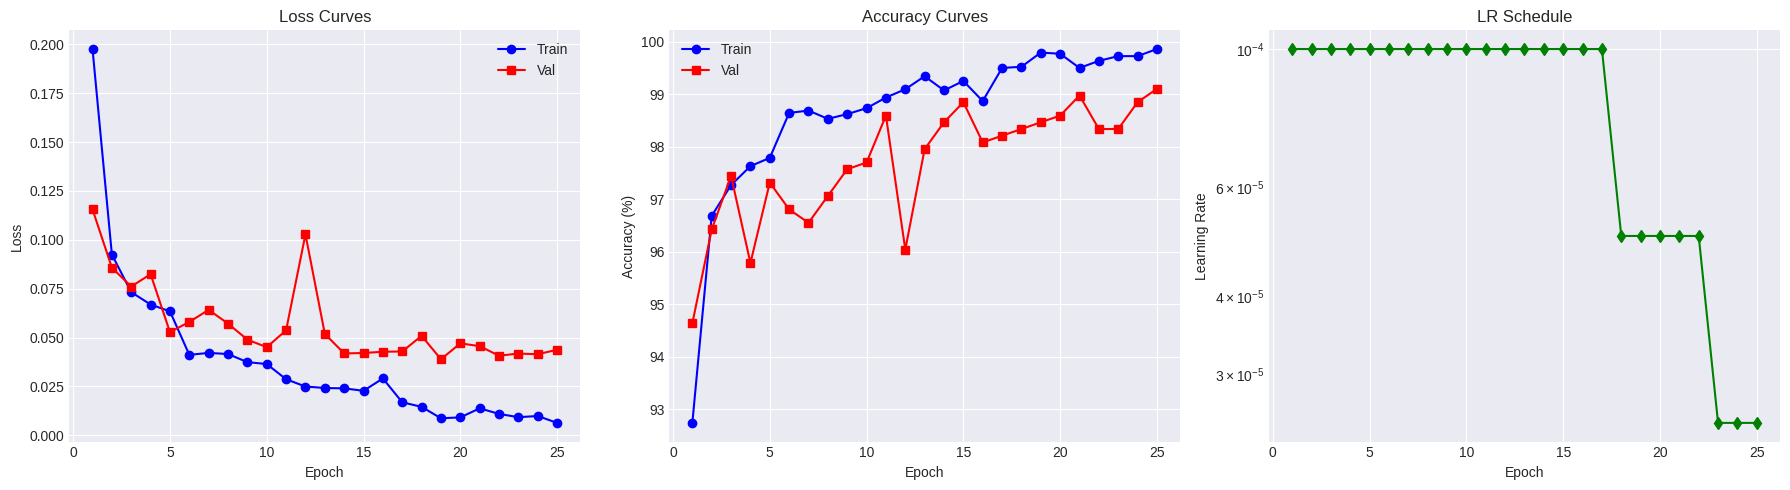

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
epochs = range(1, NUM_EPOCHS+1)

axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train')
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Curves')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train')
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy Curves')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(epochs, history['lr'], 'g-d')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('LR Schedule')
axes[2].set_yscale('log')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# 8. Performance Metrics & Evaluation

In [ ]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

y_pred, y_true, y_probs = evaluate_model(model, test_loader, device)
print('Evaluation complete')

Evaluating: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]

Evaluation complete


In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs[:, 1])

print('='*60)
print('TEST SET METRICS')
print('='*60)
print(f'Accuracy:  {accuracy*100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'AUC-ROC:   {auc:.4f}')
print('='*60)
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

TEST SET METRICS
Accuracy:  84.94%
Precision: 0.8071
Recall:    0.9974
F1-Score:  0.8922
AUC-ROC:   0.9636
              precision    recall  f1-score   support

      NORMAL       0.99      0.60      0.75       234
   PNEUMONIA       0.81      1.00      0.89       390

    accuracy                           0.85       624
   macro avg       0.90      0.80      0.82       624
weighted avg       0.88      0.85      0.84       624



## Confusion Matrix

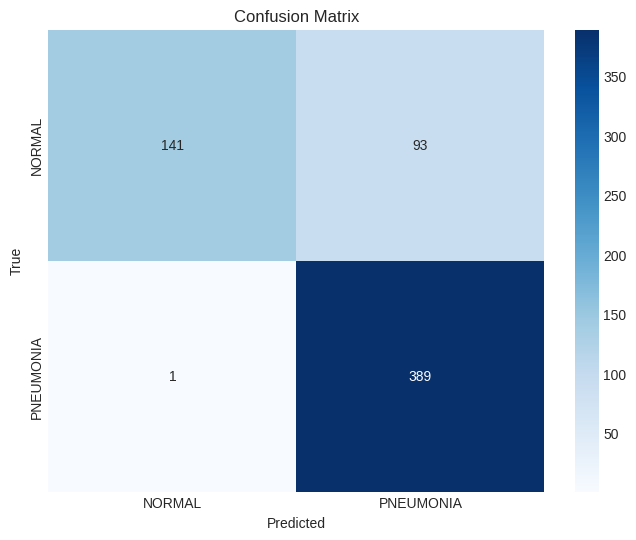

TN: 141, FP: 93, FN: 1, TP: 389


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
print(f'TN: {cm[0,0]}, FP: {cm[0,1]}, FN: {cm[1,0]}, TP: {cm[1,1]}')

## ROC Curve

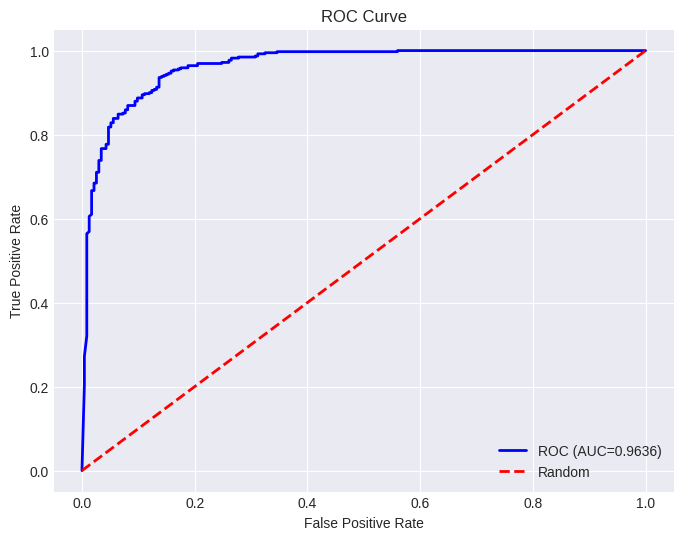

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC={auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

## Error Analysis

In [ ]:
misclassified = np.where(y_pred != y_true)[0]
print(f'Misclassified: {len(misclassified)} ({len(misclassified)/len(y_true)*100:.2f}%)')
print(f'False Positives: {len(np.where((y_pred==1) & (y_true==0))[0])}')
print(f'False Negatives: {len(np.where((y_pred==0) & (y_true==1))[0])} (CRITICAL)')

Misclassified: 94 (15.06%)
False Positives: 93
False Negatives: 1 (CRITICAL)


## Model Limitations

1. **Dataset**: Pediatric only (1-5 years), single location
2. **Binary classification**: Cannot distinguish bacterial vs viral
3. **Domain mismatch**: ImageNet → medical images
4. **No explainability**: Black box model
5. **Fixed input size**: May lose fine details
6. **Computational constraints**: Limited epochs, no hyperparameter tuning

# 9. Save Final Model

In [ ]:
torch.save({
    'model_state_dict': best_model_state,
    'model_architecture': 'DenseNet121',
    'num_classes': 2,
    'best_val_acc': best_val_acc,
    'test_accuracy': accuracy,
    'test_auc': auc,
    'hyperparameters': {'lr': LEARNING_RATE, 'batch_size': BATCH_SIZE, 'epochs': NUM_EPOCHS}
}, 'pneumonia_densenet121_best.pth')

print('Model saved as pneumonia_densenet121_best.pth')
print(f'Val Acc: {best_val_acc:.2f}%, Test Acc: {accuracy*100:.2f}%, AUC: {auc:.4f}')

Model saved as pneumonia_densenet121_best.pth
Val Acc: 99.11%, Test Acc: 84.94%, AUC: 0.9636


---

## Summary

### Project Overview:
Automated pneumonia detection using DenseNet121 pretrained on ImageNet, fine-tuned for binary classification of chest X-rays.

### Key Achievements:
- ✅ Comprehensive data preprocessing and augmentation
- ✅ Explicit training loop documentation
- ✅ Multiple performance metrics
- ✅ Error analysis and limitations identified

### Clinical Impact:
Decision support tool for rapid X-ray pre-screening, priority flagging, and diagnostic support in resource-limited settings.

**Team Gmora - BioFusion Hackathon 2026**